In [2]:
import pandas as pd

df = pd.read_csv("Finland.csv")
df = df.iloc[:, 3:]
df.set_index("Datetime (Local)", inplace=True)

df = df.rename(columns={
    df.columns[0]: "Price"        
})

df


,Price
Datetime (Local),
2015-01-01 02:00:00,23.37
2015-01-01 03:00:00,19.33
2015-01-01 04:00:00,17.66
2015-01-01 05:00:00,17.53
2015-01-01 06:00:00,18.07
...,...
2025-04-03 19:00:00,-2.12
2025-04-03 20:00:00,-2.02
2025-04-03 21:00:00,-2.03


In [9]:
import pandas as pd

# === Charger les données météo ===
weather = pd.read_csv("meteo.csv", sep=";")

# === Créer une colonne datetime ===
weather["Datetime"] = pd.to_datetime(
    weather[["Year", "Month", "Day"]].astype(str).agg("-".join, axis=1) + " " + weather["Time [Local time]"],
    errors="coerce"
)

# === Supprimer les colonnes inutiles ===
weather_cleaned = weather.drop(columns=[
    "Observation station", "Year", "Month", "Day", "Time [Local time]"
])

# === Nettoyer : mettre Datetime comme index et supprimer les lignes incomplètes ===
weather_cleaned = weather_cleaned.set_index("Datetime")
weather_cleaned = weather_cleaned.sort_index()
weather_cleaned = weather_cleaned.dropna()

# === Fusionner avec df contenant les prix de l'électricité ===
# (Assure-toi que df a un index datetime)
df.index = pd.to_datetime(df.index)  # au cas où ce n’est pas encore fait

# === Fusion par date ===
df = pd.merge(df, weather_cleaned, how="inner", left_index=True, right_index=True)

# === Résultat final ===
print(len(df))


59763


In [13]:
df = df.rename(columns={
    "Average temperature [°C]_x": "temp_avg",
    "Maximum temperature [°C]_x": "temp_max",
    "Minimum temperature [°C]_x": "temp_min",
    "Average relative humidity [%]_x": "humidity_avg",
    "Wind speed [m/s]_x": "wind_avg",
    "Maximum wind speed [m/s]_x": "wind_max",
    "Average wind direction [°]_x": "wind_dir_avg",
    "Maximum gust speed [m/s]_x": "wind_gust_max",
    "Precipitation [mm]_x": "precip",
    "Average air pressure [hPa]_x": "pressure_avg"
})

df = df[[col for col in df.columns if not col.endswith('_y')]]


df

,Price,temp_avg,temp_max,temp_min,humidity_avg,wind_avg,wind_max,wind_dir_avg,wind_gust_max,precip,pressure_avg
Datetime (Local),,,,,,,,,,,
2018-06-07 22:00:00,49.42,14.8,15.5,14,66,3.5,4.6,271,6.9,0,1010.7
2018-06-07 23:00:00,49.48,14.6,14.9,13.8,55,4.3,5.2,332,10.1,0,1011.2
2018-06-08 00:00:00,46.82,11.9,13.5,11.4,59,5.5,6.5,12,10.3,0,1012.3
2018-06-08 01:00:00,46.02,11.3,11.4,11.1,60,3.7,6.1,360,7.6,0,1012.6
2018-06-08 02:00:00,43.40,10.7,11.1,10.5,62,2.8,3.5,337,7.1,0,1012.9
...,...,...,...,...,...,...,...,...,...,...,...
2025-04-03 19:00:00,-2.12,11.8,12.5,11,58,6.1,7.7,232,11.5,0,1015.1
2025-04-03 20:00:00,-2.02,9.9,11,8.5,67,6.1,6.7,236,9.1,0,1014
2025-04-03 21:00:00,-2.03,8.1,8.7,8,75,5.1,5.9,243,8.1,0,1013.4


58575


<Axes: xlabel='Datetime (Local)'>

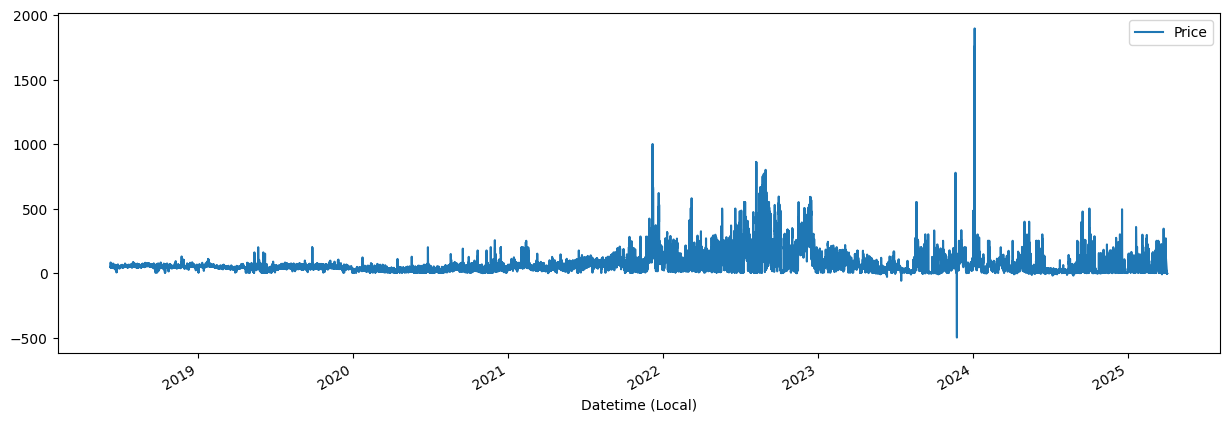

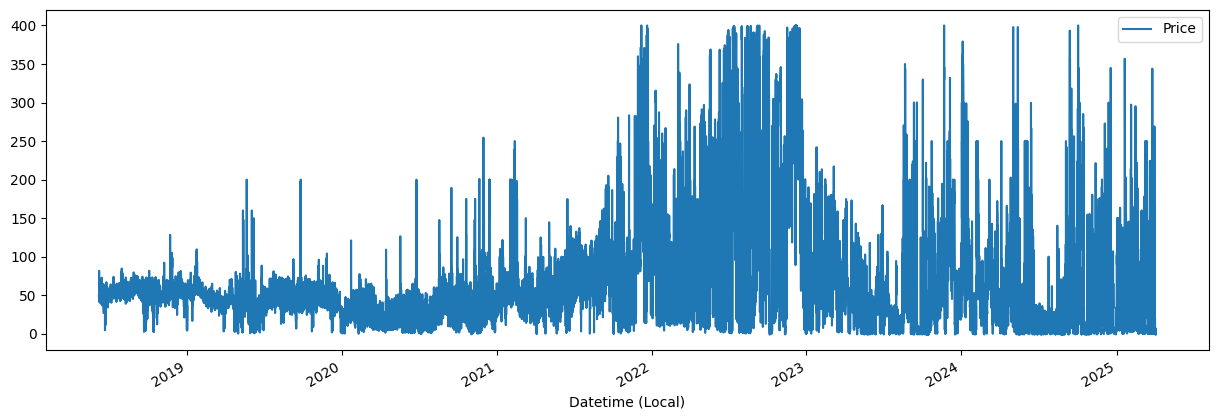

In [16]:
df.plot(figsize = (15,5))
q_low = df['Price'].quantile(0.01)
q_high = df['Price'].quantile(0.99)

df = df[(df['Price'] >= q_low) & (df['Price'] <= q_high)]

print(len(df))
df.plot(figsize = (15,5))


In [18]:
train_size = int(len(df) * 0.8)

# Séparer les ensembles
train = df.iloc[:train_size]
test = df.iloc[train_size:]

print(f"Train: {train.index.min()} → {train.index.max()}")
print(f"Test: {test.index.min()} → {test.index.max()}")


Train: 2018-06-07 22:00:00 → 2023-11-18 03:00:00
Test: 2023-11-18 04:00:00 → 2025-04-03 12:00:00


In [20]:
df.to_csv("dataset_complet.csv")


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


# --- Chargement des données ---
df = pd.read_csv("dataset_complet.csv", parse_dates=["Datetime (Local)"])
df.set_index("Datetime (Local)", inplace=True)

# Cible de prédiction
target_col = "Price"
df = df[[target_col]].dropna()
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df)

# --- Paramètres ---
input_seq_len = 24 * 50
output_seq_len = 24 * 14
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# --- Dataset ---
class PriceSequenceDataset(Dataset):
    def __init__(self, data, input_len, output_len):
        self.data = data.values.astype(np.float32)
        self.input_len = input_len
        self.output_len = output_len
        self.total_len = input_len + output_len

    def __len__(self):
        return len(self.data) - self.total_len

    def __getitem__(self, idx):
        full_seq = self.data[idx:idx + self.total_len]
        x = full_seq[:self.input_len, :]
        y = full_seq[self.input_len:, 0]
        return torch.tensor(x), torch.tensor(y)

train_loader = DataLoader(PriceSequenceDataset(train_df, input_seq_len, output_seq_len), batch_size=64, shuffle=False)
test_loader = DataLoader(PriceSequenceDataset(test_df, input_seq_len, output_seq_len), batch_size=64)

# --- Modèle ---
class LSTMForecast(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_len=336):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(1, hidden_size, num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, 1)
        self.output_len = output_len

    def forward(self, x):
        _, (hidden, cell) = self.encoder(x)
        decoder_input = x[:, -1:, :]

        outputs = []
        for _ in range(self.output_len):
            out, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            pred = self.fc_out(out)
            outputs.append(pred)
            decoder_input = pred

        outputs = torch.cat(outputs, dim=1)
        return outputs.squeeze(-1)

# --- Entraînement ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMForecast().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} - Loss moyenne : {avg_loss:.4f}")

# --- Évaluation rapide ---
model.eval()
x_test, y_test = next(iter(test_loader))
x_test, y_test = x_test.to(device), y_test.to(device)
with torch.no_grad():
    preds = model(x_test)

plt.figure(figsize=(12, 5))
plt.plot(y_test[0].cpu().numpy(), label="Vrai")
plt.plot(preds[0].cpu().numpy(), label="Prévu")
plt.legend()
plt.title("Prédiction sur 2 semaines")
plt.xlabel("Heures")
plt.ylabel("Prix")
plt.tight_layout()
plt.show()


Epoch 1/100:   3%|▎         | 21/709 [00:11<06:20,  1.81it/s]


KeyboardInterrupt: 

In [28]:
torch.save(model.state_dict(), "lstm_forecast.pth")
